In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, Amazon, Coauthor, CitationFull
from torch_geometric.loader import DataLoader
from ogb.nodeproppred import PygNodePropPredDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 분위수 손실 함수 정의
class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()
        
    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        return (mask * diff).mean()
    
# GNN 기반 분위수 모델 정의
class GCNQuantile(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNQuantile, self).__init__()
        self.conv1 = GCNConv(input_dim + 1, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, tau):
        tau = (tau - 0.5) * 12
        x = torch.cat((x, tau), dim = 1)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

In [24]:
# 단일 QR 적용 모델 학습 함수
def train_gnn_single_qr(x, y, edge_index, q=0.5):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GCNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss() 
    
    for _ in range(10000):
        optimizer.zero_grad()
        taus = torch.full((x.size(0), 1), q)
        loss = loss_fn(model(x, edge_index, taus), y, taus)
        loss.backward()
        optimizer.step()
    
    return model

# 신뢰구간 학습 QR 적용 모델
def train_gnn_ci_qr(x, y, edge_index, ci=0.9):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GCNQuantile(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    loss_fn = QuantileLoss()
    
    lower_tau = (1 - ci) / 2  # 예: 90% 신뢰구간이면 5% (0.05)
    upper_tau = 1 - (1 - ci) / 2  # 예: 90% 신뢰구간이면 95% (0.95)
    
    for _ in range(10000):
        optimizer.zero_grad()
        taus = torch.cat([
            torch.full((x.size(0) // 2, 1), lower_tau),
            torch.full((x.size(0) - x.size(0) // 2, 1), upper_tau)
        ], dim=0)
        loss = loss_fn(model(x, edge_index, taus), y, taus)
        loss.backward()
        optimizer.step()
    
    return model

In [40]:
# 데이터셋 로드
# data = dataset = Planetoid(root='/tmp/Cora', name='Cora')[0]

dataset = PygNodePropPredDataset(name="ogbn-arxiv")
data = dataset[0]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:27<00:00,  2.98it/s]
Processing...


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 12264.05it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]

Saving...



Done!


In [42]:
x = data.x
y = data.y
edge_index = data.edge_index

In [26]:
# 개별 분위수 모델 학습
net_005 = train_gnn_single_qr(x, y, edge_index, q=0.05)
net_095 = train_gnn_single_qr(x, y, edge_index, q=0.95)

# 신뢰 분위수 모델 학습
net_joint = train_gnn_ci_qr(x, y, edge_index, ci=0.9) 

In [27]:
# 개별 학습된 모델을 사용한 예측값
num_nodes = data.x.shape[0]

predictions_sep = {
    0.05: net_005(x, edge_index, torch.full((num_nodes, 1), 0.05)).detach().numpy(),
    0.95: net_095(x, edge_index, torch.full((num_nodes, 1), 0.95)).detach().numpy(),
}

# 조인트 학습된 모델을 사용한 예측값
predictions_joint = {
    tau: net_joint(x, edge_index, torch.full((num_nodes, 1), tau)).detach().numpy()
    for tau in [0.05, 0.95]
}

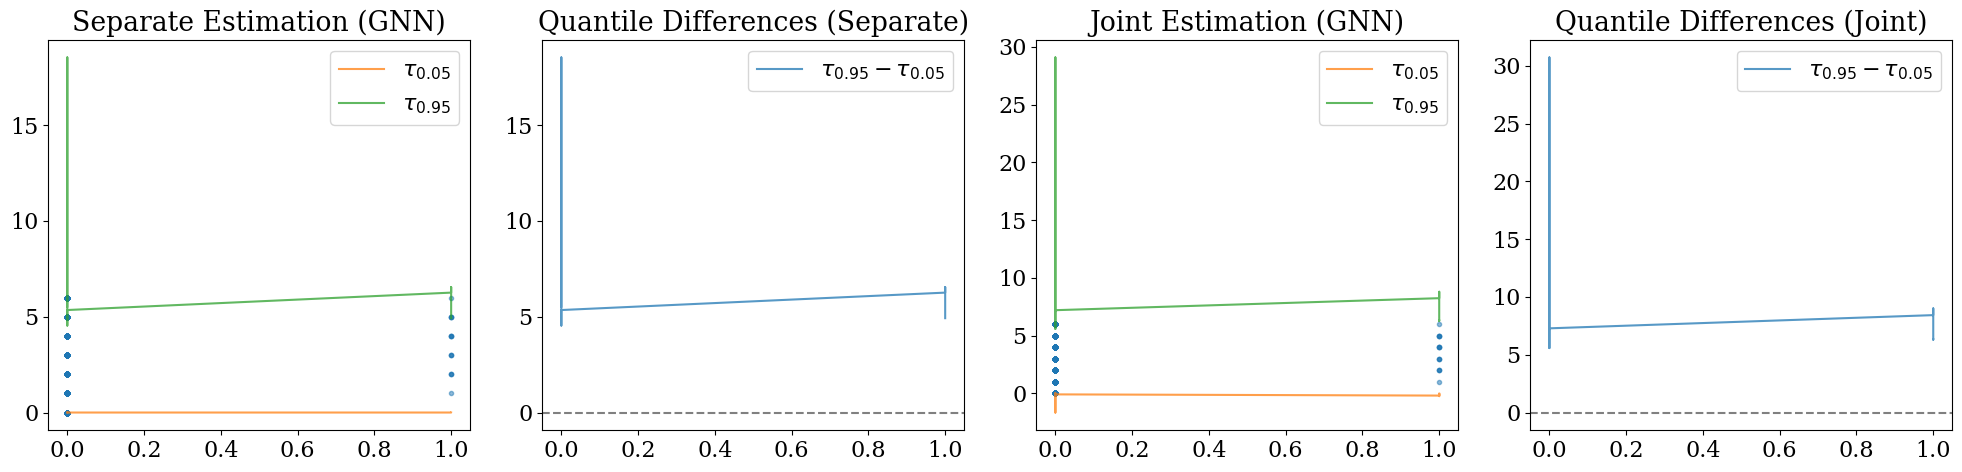

In [33]:
# 정렬된 노드 인덱스
o = torch.sort(x[:, 0])[1]

# 시각화
plt.figure(figsize=(20, 5))
plt.rc('font', size=16)
plt.rc('font', family='serif')

# (1) 개별 학습된 분위수 모델 (Separate Estimation)
plt.subplot(1, 4, 1)
plt.title("Separate Estimation (GNN)")
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_sep[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

# (2) 분위수 차이 시각화 (Separate Estimation)
plt.subplot(1, 4, 2)
plt.title("Quantile Differences (Separate)")
plt.plot(x[o, 0].numpy(), (predictions_sep[0.95] - predictions_sep[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
plt.legend()

# (3) 조인트 학습된 분위수 모델 (Joint Estimation)
plt.subplot(1, 4, 3)
plt.title("Joint Estimation (GNN)")
plt.plot(x[o, 0].numpy(), y[o].numpy(), '.', alpha=0.5)
for tau in [0.05, 0.95]:
    plt.plot(x[o, 0].numpy(), predictions_joint[tau][o], alpha=0.75, label=f"$\\tau_{{{tau}}}$")
plt.legend()

# (4) 분위수 차이 시각화 (Joint Estimation)
plt.subplot(1, 4, 4)
plt.title("Quantile Differences (Joint)")
plt.plot(x[o, 0].numpy(), (predictions_joint[0.95] - predictions_joint[0.05])[o], alpha=0.75, label="$\\tau_{0.95} - \\tau_{0.05}$")
plt.axhline(0, ls="--", color="gray")
plt.legend()

# 결과 저장 및 표시
plt.tight_layout()
# plt.savefig("gnn_joint_vs_separate_estimation.pdf")
plt.show()

In [7]:
# GNN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [4]:
# 데이터셋 분할: Train/ Calibration / Test
num_nodes = data.x.shape[0]
indices = np.arange(num_nodes)
np.random.shuffle(indices)

train_ratio, calib_ratio = 0.6, 0.2 # 20% test
train_size = int(num_nodes * train_ratio)
calib_size = int(num_nodes * calib_ratio)

train_idx = indices[:train_size]
calib_idx = indices[train_size:train_size + calib_size]
test_idx = indices[train_size + calib_size:]

# new 마스크 설정
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True

data.calib_mask = torch.zeros(num_nodes, dtype=torch.bool)  # Calibration Mask 추가
data.calib_mask[calib_idx] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True

In [9]:
# 모델 훈련 함수
def train_gnn_cp(x, y, edge_index):
    input_dim = x.shape[1]
    hidden_dim = 128
    output_dim = 1
    
    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    
    for _ in range(10000):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    return model

# Conformal Prediction 보정 함수 (Calibration Set 사용)
def conformal_prediction_calibrate(model, data, alpha=0.1):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index).numpy()
        labels = data.y.numpy()
        scores = np.abs(logits - labels)  # 비순응 점수 계산 (회귀)
    
    # Calibration 데이터만 사용하여 신뢰구간 보정
    qhat = np.quantile(scores[data.calib_mask], 1 - alpha)
    return qhat

# Conformal Prediction 적용 함수
def conformal_prediction_predict(model, data, qhat):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index).numpy()
        lower_bound = logits - qhat
        upper_bound = logits + qhat
    return lower_bound, upper_bound

In [10]:
# Conformal Prediction 수행
model = train_gnn_cp(x, y, edge_index)
qhat = conformal_prediction_calibrate(model, data, alpha=0.1)
lower_bound, upper_bound = conformal_prediction_predict(model, data, qhat)

# 결과 출력
print("Calibration Quantile Threshold:", qhat)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


NameError: name 'model' is not defined